In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time

# Функция для обучения

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
log_df = pd.DataFrame({'model': [], 'epoch': [], 'train_loss': [], 'test_loss': []})

def add_to_log(train_loss_log, test_loss_log, model_name):
    for i, (tr, ts) in enumerate(zip(train_loss_log, test_loss_log)):
        log_df.loc[len(log_df)] = model_name, i+1, tr, ts

def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    train_loss_log = []
    test_loss_log = []
    try:
        for epoch in range(num_epochs):
            train_l_sum, train_acc_sum, train_n, start = 0.0, 0.0, 0, time.time()
            net.train()
            for i, (X, y) in enumerate(train_iter):
                X, y = X.to(device), y.to(device)
                trainer.zero_grad()
                try:
                    y_hat = net(X)
                except:
                    y_hat, _ = net(X)
                l = loss(y_hat, y)
                l.backward()
                trainer.step()
                train_l_sum += l.item()
                train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
                train_n += y.shape[0]

                if i % 100 == 0:
                    print(f'Step {i}. Time since epoch: {time.time() -  start:.3f}. '
                          f'Train acc: {train_acc_sum / train_n:.3f}. Train loss: {train_l_sum / train_n:.4f}')

            test_l_sum, test_acc_sum, test_n = 0.0, 0.0, 0
            net.eval()
            for X, y in test_iter:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                l = loss(y_hat, y)
                test_l_sum += l.item()
                test_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
                test_n += y.shape[0]

            train_loss, test_loss = train_l_sum / train_n, test_l_sum / test_n
            train_loss_log.append(train_loss), test_loss_log.append(test_loss)
            print('-' * 20)
            print(f'Epoch {epoch + 1}, Train loss {train_loss:.4f}, Train acc {train_acc_sum / train_n:.3f}' \
                  f', Test loss {test_loss:.4f}, Test acc {test_acc_sum / test_n:.3f}, Time {time.time() - start:.1f} sec')
            print('-' * 20)
        return train_loss_log, test_loss_log
    except:
        return train_loss_log, test_loss_log

# Данные

In [4]:
BATCH_SIZE = 256

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='letters', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='letters', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:11<00:00, 48048622.76it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


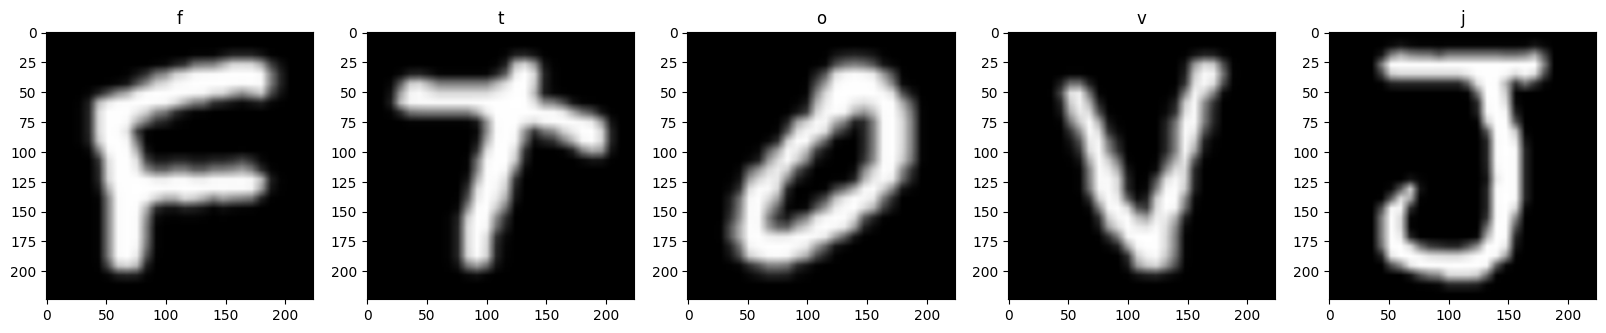

In [5]:
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
fig = plt.figure(figsize=(20, 10))

for i in range(5):
    subplot = fig.add_subplot(1, 5, i+1)
    num = np.random.randint(0, train_dataset.data.shape[0])
    img = train_dataset[num][0][0]
    plt.imshow(img.T, cmap='gray');
    subplot.set_title('%s' % idx_to_class[train_dataset[num][1]]);

In [6]:
print(train_dataset.classes)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


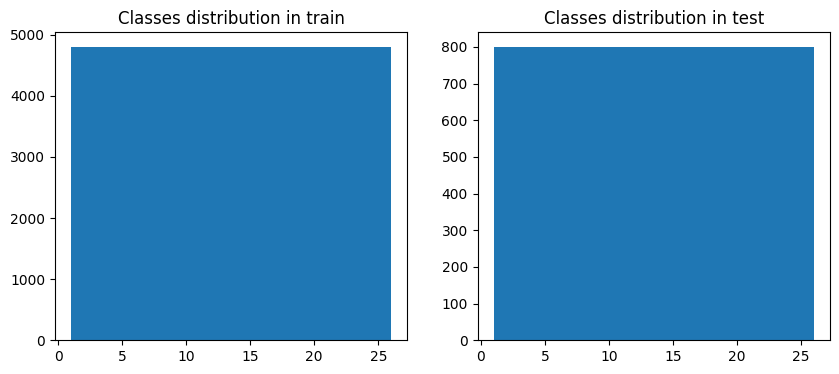

In [ ]:
train_classes_dist = [i[1] for i in train_dataset]
test_classes_dist = [i[1] for i in test_dataset]
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.hist(train_classes_dist, bins=len(set(train_classes_dist)))
plt.title('Classes distribution in train')

plt.subplot(122)
plt.hist(test_classes_dist, bins=len(set(test_classes_dist)))
plt.title('Classes distribution in test');

# ResNet 18

In [ ]:
net = tv.models.resnet18(pretrained=True)

for param in net.parameters():
    param.requires_grad = False

net.fc = nn.Linear(in_features=net.fc.in_features, out_features=len(train_dataset.classes))

print("Params to learn:")
params_to_update = []
for name, param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update)
train_loss_log, test_loss_log = train(net, train_iter, test_iter, trainer, num_epochs=10)
add_to_log(train_loss_log, test_loss_log, model_name='ResNet 18')

Step 0. Time since epoch: 1.719. Train acc: 0.039. Train loss: 3.5426
Step 100. Time since epoch: 66.802. Train acc: 0.537. Train loss: 1.9250
Step 200. Time since epoch: 131.019. Train acc: 0.637. Train loss: 1.4931
Step 300. Time since epoch: 194.696. Train acc: 0.684. Train loss: 1.2803
Step 400. Time since epoch: 257.989. Train acc: 0.710. Train loss: 1.1509
--------------------
Epoch 1, Train loss 1.0694, Train acc 0.727, Test loss 0.6697, Test acc 0.811, Time 363.1 sec
--------------------
Step 0. Time since epoch: 0.612. Train acc: 0.793. Train loss: 0.7059
Step 100. Time since epoch: 63.920. Train acc: 0.819. Train loss: 0.6474
Step 200. Time since epoch: 127.353. Train acc: 0.820. Train loss: 0.6317
Step 300. Time since epoch: 190.447. Train acc: 0.823. Train loss: 0.6190
Step 400. Time since epoch: 253.592. Train acc: 0.824. Train loss: 0.6093
--------------------
Epoch 2, Train loss 0.5991, Train acc 0.826, Test loss 0.5531, Test acc 0.834, Time 358.0 sec
-------------------

# VGG 16

In [ ]:
net = tv.models.vgg16(pretrained=True)

for param in net.parameters():
    param.requires_grad = False

net.classifier = nn.Linear(in_features=net.classifier[0].in_features, out_features=len(train_dataset.classes))

print("Params to learn:")
params_to_update = []
for name, param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.5MB/s]


Params to learn:
	 classifier.weight
	 classifier.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update)
train_loss_log, test_loss_log = train(net, train_iter, test_iter, trainer, num_epochs=5)
add_to_log(train_loss_log, test_loss_log, model_name='VGG 16')

Step 0. Time since epoch: 1.867. Train acc: 0.039. Train loss: 3.3160
Step 100. Time since epoch: 159.832. Train acc: 0.856. Train loss: 0.4909
Step 200. Time since epoch: 317.781. Train acc: 0.884. Train loss: 0.3795
Step 300. Time since epoch: 476.846. Train acc: 0.898. Train loss: 0.3289
Step 400. Time since epoch: 636.025. Train acc: 0.905. Train loss: 0.3049
--------------------
Epoch 1, Train loss 0.2899, Train acc 0.909, Test loss 0.2300, Test acc 0.925, Time 902.4 sec
--------------------
Step 0. Time since epoch: 1.547. Train acc: 0.926. Train loss: 0.1853
Step 100. Time since epoch: 160.219. Train acc: 0.946. Train loss: 0.1554
Step 200. Time since epoch: 319.612. Train acc: 0.948. Train loss: 0.1501
Step 300. Time since epoch: 478.984. Train acc: 0.951. Train loss: 0.1423
Step 400. Time since epoch: 638.095. Train acc: 0.952. Train loss: 0.1411
--------------------
Epoch 2, Train loss 0.1397, Train acc 0.953, Test loss 0.2333, Test acc 0.925, Time 906.1 sec
-----------------

# DenseNet 161

In [50]:
net = tv.models.densenet161(pretrained=True)

for param in net.parameters():
    param.requires_grad = False

net.classifier = nn.Linear(in_features=net.classifier.in_features, out_features=len(train_dataset.classes))

print("Params to learn:")
params_to_update = []
for name, param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update)
train_loss_log, test_loss_log = train(net, train_iter, test_iter, trainer, num_epochs=10)
add_to_log(train_loss_log, test_loss_log, model_name='DenseNet 161')

Step 0. Time since epoch: 2.719. Train acc: 0.039. Train loss: 3.3890
Step 100. Time since epoch: 244.954. Train acc: 0.561. Train loss: 1.7826
Step 200. Time since epoch: 486.146. Train acc: 0.647. Train loss: 1.4025
Step 300. Time since epoch: 727.727. Train acc: 0.691. Train loss: 1.2099
Step 400. Time since epoch: 969.874. Train acc: 0.717. Train loss: 1.0925
--------------------
Epoch 1, Train loss 1.0193, Train acc 0.733, Test loss 0.6545, Test acc 0.814, Time 1358.8 sec
--------------------
Step 0. Time since epoch: 2.387. Train acc: 0.805. Train loss: 0.6600
Step 100. Time since epoch: 242.975. Train acc: 0.822. Train loss: 0.6214
Step 200. Time since epoch: 484.250. Train acc: 0.824. Train loss: 0.6099
Step 300. Time since epoch: 725.285. Train acc: 0.829. Train loss: 0.5935
Step 400. Time since epoch: 966.318. Train acc: 0.830. Train loss: 0.5839
--------------------
Epoch 2, Train loss 0.5752, Train acc 0.832, Test loss 0.5357, Test acc 0.842, Time 1353.9 sec
---------------

# Inception v3

In [37]:
BATCH_SIZE = 256

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='letters', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='letters', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [38]:
net = tv.models.inception_v3(pretrained=True)

for param in net.parameters():
    param.requires_grad = False

net.fc = nn.Linear(in_features=net.fc.in_features, out_features=len(train_dataset.classes))

print("Params to learn:")
params_to_update = []
for name, param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update)
train_loss_log, test_loss_log = train(net, train_iter, test_iter, trainer, num_epochs=10)
add_to_log(train_loss_log, test_loss_log, model_name='Inception v3')

Step 0. Time since epoch: 1.726. Train acc: 0.043. Train loss: 3.3591
Step 100. Time since epoch: 176.903. Train acc: 0.411. Train loss: 2.2533
Step 200. Time since epoch: 351.676. Train acc: 0.493. Train loss: 1.9031
Step 300. Time since epoch: 526.664. Train acc: 0.534. Train loss: 1.7178
Step 400. Time since epoch: 701.507. Train acc: 0.558. Train loss: 1.6040
--------------------
Epoch 1, Train loss 1.5330, Train acc 0.573, Test loss 1.0360, Test acc 0.705, Time 984.7 sec
--------------------
Step 0. Time since epoch: 1.681. Train acc: 0.652. Train loss: 1.1095
Step 100. Time since epoch: 176.152. Train acc: 0.652. Train loss: 1.1461
Step 200. Time since epoch: 350.663. Train acc: 0.652. Train loss: 1.1404
Step 300. Time since epoch: 525.242. Train acc: 0.657. Train loss: 1.1245
Step 400. Time since epoch: 700.103. Train acc: 0.657. Train loss: 1.1174
--------------------
Epoch 2, Train loss 1.1105, Train acc 0.659, Test loss 0.8909, Test acc 0.739, Time 983.5 sec
-----------------

# Сводная таблица и графики оптимизации

In [52]:
log_df

,model,epoch,train_loss,test_loss
0,ResNet 18,1,1.069383,0.669719
1,ResNet 18,2,0.599110,0.553130
2,ResNet 18,3,0.519979,0.506752
3,ResNet 18,4,0.480111,0.481227
4,ResNet 18,5,0.454870,0.464924
5,ResNet 18,6,0.436998,0.453578
6,ResNet 18,7,0.423467,0.445229
7,ResNet 18,8,0.412752,0.438842
8,ResNet 18,9,0.403991,0.433813
9,ResNet 18,10,0.396655,0.429765


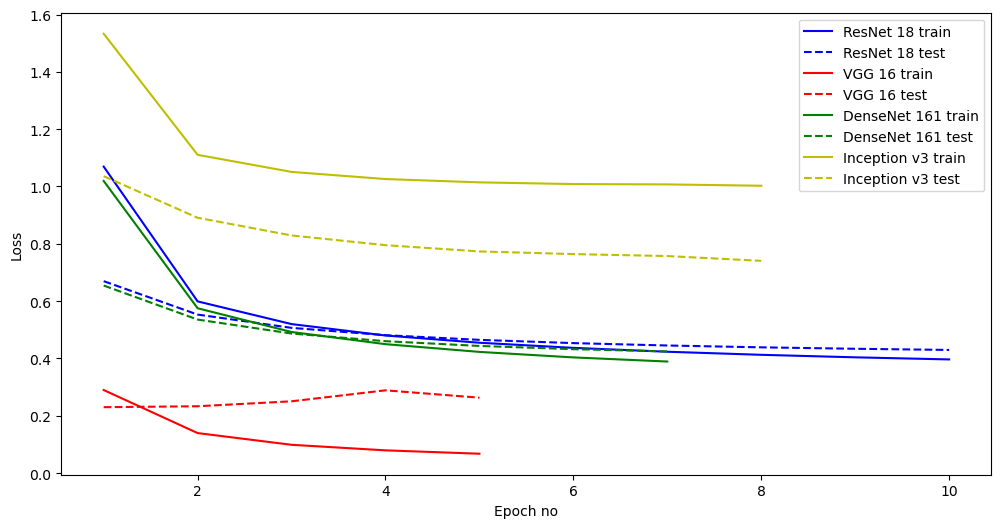

In [53]:
plt.figure(figsize=(12,6))

for mod, color in zip(log_df['model'].unique(), ['b', 'r', 'g', 'y']):
    df = log_df[log_df['model'] == mod]
    plt.plot(df.epoch, df.train_loss, label=mod + ' train', c=color)
    plt.plot(df.epoch, df.test_loss, label=mod + ' test', linestyle='dashed', c=color)

plt.legend()
plt.xlabel('Epoch no')
plt.ylabel('Loss')
plt.show()